In [1]:
# Import The Libraries
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy as sp, warnings
from matplotlib import cm
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans,MiniBatchKMeans
from wordcloud import WordCloud
sns.set_style("whitegrid")
from keras.layers import Dense,Input
from keras.models import Sequential, Model
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples,silhouette_score

In [2]:
dataset=pd.read_excel('online_retail_II.xlsx',sheet_name=None)
Data_Clean = dataset['Year 2009-2010'].append(dataset['Year 2010-2011'],ignore_index=True)
#remove all customers with NA customer ID
Data_Clean = Data_Clean[Data_Clean['Customer ID'].notna()]
#remove the negative quantity values and duplicate transactions
data = Data_Clean[(Data_Clean['Price'] > 0) & (Data_Clean['Quantity']>0)]
data.drop_duplicates(inplace = True)
data['Final_Price'] = data['Price'] * data['Quantity']

#### Find the most common words and remove them

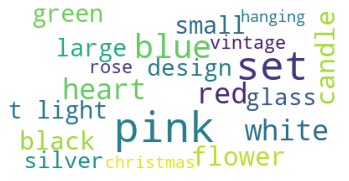

In [3]:
desc=data['Description'].apply(str).unique()
desc_1=[w.lower() for w in desc]
desc_1=' '.join([word for word in desc_1])
word_cl = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=ENGLISH_STOP_WORDS).generate(desc_1)
plt.imshow(word_cl)
plt.axis("off")
plt.show()

In [4]:
stop_words =['flower','rose','candle','heart','small', 'large','light','black', 'red', 'blue', 'green', 'white',  'pink','glass', 'silver','set','vintage','design','hanging',
                  'of','in','s','f','t']

In [5]:
#Apply TF-IDF 
distances = []
vec = TfidfVectorizer(stop_words=stop_words)
X_var = vec.fit_transform(desc) 

Product Category: 1


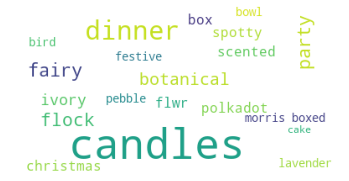

Product Category: 2


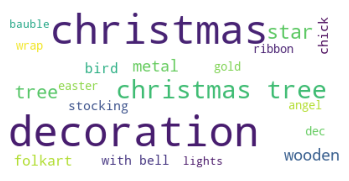

Product Category: 3


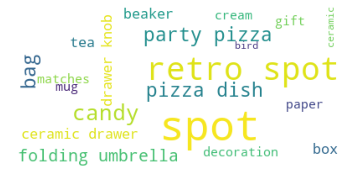

Product Category: 4


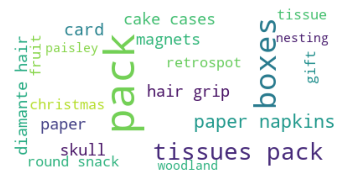

Product Category: 5


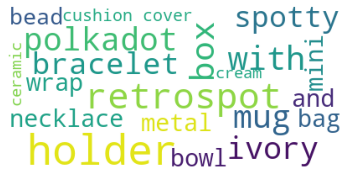

Product Category: 6


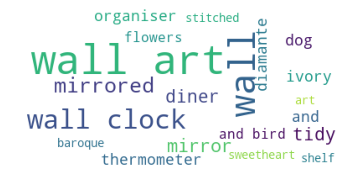

In [6]:
#Clustering of products
model = MiniBatchKMeans(6, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_var)
label=model.labels_
desc_cate=pd.DataFrame(list(zip(desc,label)),columns=['Description','Prod_category'])

for r in range(0,6):
    print('Product Category: {}'.format(r+1))
    t=desc_cate[desc_cate.Prod_category==r]['Description'].str.cat(sep=' ')
    t=t.lower()
    t=' '.join([word for word in t.split()])
    word_cl = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=stop_words).generate(t)
    plt.axis("off")
    plt.imshow(word_cl)
    plt.show()

### Calculate total cost per category for each customer

In [7]:
or_cate= pd.merge(data,desc_cate,on='Description',how='inner')

#grouping on the basis of price for each category to get customer level data
cust_level_data=or_cate.pivot_table(index=["Customer ID"], columns='Prod_category', values='Final_Price',
                    aggfunc='sum').reset_index()
cust_level_data=cust_level_data.fillna(0)
cust_level_data.head()

Prod_category,Customer ID,0,1,2,3,4,5
0,12346.0,0.0,14.98,7.49,0.0,77533.99,0.0
1,12347.0,15.3,47.60,0.00,92.4,4745.83,20.4
2,12348.0,0.0,94.20,0.00,466.8,1458.40,0.0
3,12349.0,0.0,10.20,45.45,60.6,4292.54,19.9
4,12350.0,0.0,0.00,0.00,0.0,334.40,0.0


In [8]:
cust_level_data['total']=abs(cust_level_data[0])+abs(cust_level_data[1])+abs(cust_level_data[2])+abs(cust_level_data[3])+abs(cust_level_data[4])+abs(cust_level_data[5])
cust_level_data[0]=abs(cust_level_data[0])/cust_level_data['total']
cust_level_data[1]=abs(cust_level_data[1])/cust_level_data['total']
cust_level_data[2]=abs(cust_level_data[2])/cust_level_data['total']
cust_level_data[3]=abs(cust_level_data[3])/cust_level_data['total']
cust_level_data[4]=abs(cust_level_data[4])/cust_level_data['total']
cust_level_data[5]=abs(cust_level_data[5])/cust_level_data['total']
cust_level_data.fillna(0)
cust_level_data=cust_level_data.drop(['total'],axis=1)
#cust_level_data.to_pickle('category_clusters_6_Cat_4clus.pickle') 

## Model 1 : Using the above categories as an input with RFM values for clustering.

In [9]:
#read prod category and rfm data
prod_cat = pd.read_pickle('category_clusters_6_Cat_4clus.pickle')
rfm = pd.read_pickle('rfm.pkl')

In [10]:
final_data = pd.merge(prod_cat,rfm,on='Customer ID')
final_data_new = pd.merge(prod_cat,rfm,on='Customer ID')
final_data.drop(['RFM_Segment','Customer ID','R','F','M','cluster','RFM_Score'],axis = 'columns',inplace=True)
final_data.rename(columns={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5'})

#Rescaling
numeric_columns = final_data.columns.values.tolist()
scaler = MinMaxScaler() 
final_data[numeric_columns] = scaler.fit_transform(final_data[numeric_columns])

In [11]:
#Auto encoders code
model_input = Input( shape = (9, ))
i_1 = Dense(7, activation = 'relu')(model_input)
i_1 = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(i_1)
i_1 = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(i_1)
i_1 = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(i_1)
encod = Dense(2, activation = 'relu', kernel_initializer='glorot_uniform')(i_1)
i_1 = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(encod)
i_1 = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(i_1)
decoder = Dense(9, kernel_initializer='glorot_uniform')(i_1)
autoencoder = Model(model_input, decoder)
encoder = Model(model_input, encod)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')
autoencoder.fit(final_data, final_data, batch_size= 120, epochs = 25, verbose = 1)
output = encoder.predict(final_data)

Epoch 1/25
49/49 [==============================] - 2s 19ms/step - loss: 0.0361
Epoch 2/25
49/49 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 3/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0026
Epoch 4/25
49/49 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 5/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0024
Epoch 6/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 7/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 8/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0020
Epoch 9/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0022: 0s - loss
Epoch 10/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 11/25
49/49 [==============================] - 1s 20ms/step - loss: 0.0021
Epoch 12/25
49/49 [==============================] - 1s 19ms/step - loss: 0.0025
Epoch 13/25
49/49 [=======

In [12]:
#fir the encoder output to kmeans
kmeans = KMeans(3)
kmeans.fit(output)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(final_data)

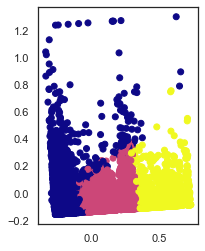

In [30]:
#for visualisation
pca = PCA(n_components = 2)
plt.grid(False)
sns.reset_orig
prin_comp = pca.fit_transform(final_data)
plt.scatter(prin_comp[:,0],prin_comp[:,1],c=labels,cmap="plasma")
ax = plt.gca()
ax.set_aspect(1) 

In [14]:
#count of customers in each cluster
output_cluster = pd.concat([final_data_new, pd.DataFrame({'cluster_final':labels})], axis = 1)
print(output_cluster['cluster_final'].value_counts())
silhouette_avg = silhouette_score(final_data, y_kmeans)
print('score de silhouette: {}'.format(silhouette_avg))

0    3413
1    1604
2     861
Name: cluster_final, dtype: int64
score de silhouette: 0.5297182585695746


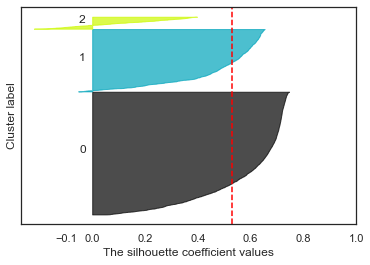

In [31]:
#reference: https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
sample_silhouette_values = silhouette_samples(final_data, y_kmeans)
fig, (ax1) = plt.subplots(1, 1)
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_kmeans == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_aspect(1) 
sns.set(font_scale = 1.5)

plt.show()

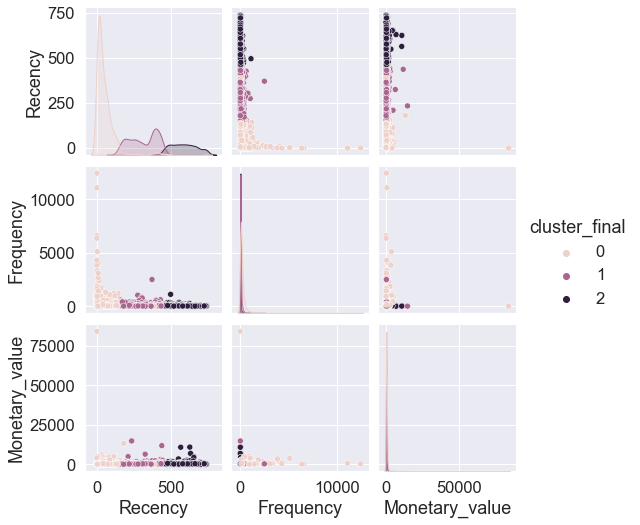

In [19]:
output_cluster_1 = output_cluster[['Recency','Frequency','Monetary_value','cluster_final']]
sns.set(font_scale = 1.5)
sns.pairplot(output_cluster_1, hue = 'cluster_final')

In [32]:
output_cluster.to_csv('3_clusters_M1_v2.csv')